In [1]:
import pandas as pd
import os
import re
import numpy as np
import fasttext
from tqdm import tqdm

## About the input file

- input file `predict_categories_dataset_ocrs.jsonl.gz` weights 335.8 MB  
about the file : https://openfoodfacts.org/data/dataforgood2022/big/predict_categories_dataset_documentation.txt  download the file : https://openfoodfacts.org/data/dataforgood2022/big/predict_categories_dataset_ocrs.jsonl.gz

- each line of the jsonl file contains OCRs associated with a barcode.
- each OCR contains text, potentially in different languages

## What is done in this notebook
1. Make the notebook
- A DataFrame is made from the jsonl.gz
- All the OCRs of a product are concatenated
- For each product the different languages are detected.  
- When the text is not too long it remains as is, it is only cleaned with the `text_cleaner` there isnt' any text selection at all.

Problem: in some case the text is too long. We need a way to extract only relevant words

2. Selection strategies:
- only the main language is kept (i.e the lang in which there are many words and a good confidence score)
- TFIDF Selection strategy : The approach here is to filter by language and to create a TFIDF matrix. For each product of a given language we keep only the N-top words according to their TFIDF score.
- language intersection strategy:
We add words that are found in all the different languages detected.
- OCR intersection strategy:
We add words that are found in all the different OCRs (i.e all the different images).
- Big words on the images:
Finally we add the biggest words in the images. They are found by choosing words that have the biggest bounding polygon (anchor detection box) for the least text. In other words we choose the words that have the biggest detection-box-size / character-length ratio






#- As there are many languages to work with, It is suggested to work with a Multilanguage sentence transformer.
#- As the sentences can't properly be identified on a product we behave like there is only one big sentence


In [2]:
path_ocrs = os.path.abspath("../datasets/predict_categories_dataset_ocrs.jsonl.gz")

In [3]:
def get_row_from_json_for_df(json_line: dict) -> list:
    """ extract items from json and returns a row to put in a dataframe 
    Parameters
    ----------
    json_line: dict 
        dictionnary loaded from a line in the jsonl file.
    
    Returns
    -------
    row: list
        list with items [code, ocr_texts, keys]
            code: barcode of the product
            ocr_texts: concatenated texts coming from all the images
            keys: keys of all the images; for example 004/150/000/7229/2.json  <-- "2" is the key.
    """
    code = json_line['code']
    if "ocrs" in json_line:
        texts = []
        keys =  list(json_line['ocrs'].keys())
        for key in keys:
            ocr_text = json_line['ocrs'][key]['text']
            texts.append(ocr_text)
    row = [code, " ".join(texts), keys]
    return row

In [4]:
def get_item_from_json_for_dict(json_line: dict, ocr_text_dict: dict) -> dict:
    """ extracts ocr text from all images, for a given barcode.
    returns a dict with new elements coming from json_line.
    
    Parameters
    ----------
    json_line: dict 
        dictionnary loaded from a line in the jsonl file.
    ocr_text_dict: dict
        dictionnary in the following format {barcode: {key: ocr_text}}
    
    Returns
    -------
    ocr_text_dict: dict
        dictionnary ocr_text_dict with new elements coming from json_line.
    """
    
    code = json_line['code']
    if "ocrs" in json_line:
        keys =  list(json_line['ocrs'].keys())
        if len(keys) >0:
            ocr_text_dict[str(code)] = {}
            for key in keys:
                ocr_text_dict[str(code)][key] = json_line['ocrs'][key]['text']
    return ocr_text_dict

In [5]:
def artificial_sentence_split(text:str, n_words_per_sentence:int = 8)-> list['str']: 
    """splits artificially a text, based on a pre-defined number of words. 
    On average there are 15 words per sentence.
    
    Parameters
    ----------
    text: str 
        input text.
    n_words_per_sentence: int
        number of words in each artificial sentence.
    
    Returns
    -------
    sentence_split: list
        a list of sentences containing 8 words each.
    """
    txt_split = text.split()
    total_words = len(txt_split)
    if total_words >= n_words_per_sentence:
        n_sentences = total_words // n_words_per_sentence
        rest = total_words % n_words_per_sentence
        chunks = [[i*n_words_per_sentence, (i+1)*n_words_per_sentence ] for i in range(n_sentences)]
        chunks[-1][1]+=rest
    else:
        chunks = [[0, total_words]]
    sentence_split = [" ".join(txt_split[slice(*chunk)]) for chunk in chunks]
    return sentence_split


def get_clean_lists_from_fasttext(lang_labels: list['list'], probs_list: list['list']):
    """ fasttexts returns a list of lists for language labels and probs_list.
    for each item in the list the argmax is taken

    Parameters
    ----------
    lang_labels: list of lists .
        list of langages found, for each OCR text.
    probs_list: list of lists.
        list of all the probabilities of the languages, for each OCR text.
    
    Returns
    -------
    lang_labels_output: list
        list containing the main language for each OCR.
    prob_list_output: list
        The associated probabilities of the languages in lang_labels_output.
    """
    main_lang_idx = [np.argmax(items) for items in probs_list]
    lang_labels_output = [lang_label[i].split('__label__')[1] for lang_label, i in zip(lang_labels, main_lang_idx)]
    prob_list_output = [prob_list[i] for prob_list,i in zip(probs_list, main_lang_idx)]
    return lang_labels_output, prob_list_output


def text_lang_split(text:str)-> dict:
    """
    takes text as input and splits it in a dictionnary with languages found as keys.

    Parameters
    ----------
    text: str
    
    Returns
    -------
    main_lang: str
        language that contains the most words in the dictionnary
    sorted_dict: dict:
        dictionnary sorted in the following format : {"lang": {"prob": prob, "len_text":len_text, "text": text}}
        text: text found with in a given language.
        len_text: the length of the text.
        prob: a list of probabilities, each probability corresponds to a sentence.
    """
    text = re.sub(r"\n", " ", text)
    text = re.sub("\.+", ".", text)
    lang_dict = {}
    sentences = artificial_sentence_split(text)
    langs, probs = get_langs(sentences)
    for sentence, lang, prob in zip(sentences, langs, probs):
       
        if lang in lang_dict:
            lang_dict[lang]["prob"].append(prob)
            lang_dict[lang]["len_text"] += len(sentence)
            lang_dict[lang]["text"]+= " " + sentence
            
        else:
            lang_dict[lang] = {"prob": prob}
            lang_dict[lang]["len_text"] = len(sentence)
            lang_dict[lang]["text"] = sentence
            
    sorted_dict = {k: v for k, v in sorted(lang_dict.items(), key=lambda item: item[1]["len_text"], reverse = True)}
    main_lang = next(iter(sorted_dict))
    return main_lang, sorted_dict

def get_langs(sentences:list):
    """ detects languages and returns for each sentence the most probable one with its associated probability.
    Parameters
    ----------
    sentences: list
        list of string sentences.
    
    Returns:
    ----------
    langs: list 
        list of languages.
    probs: list
        list of proababilities.
    """
    lang_labels, probs_list = model.predict(sentences)
    langs, probs = get_clean_lists_from_fasttext(lang_labels, probs_list)
    return langs, probs


### Make DataFrame and ocr_text_dict from jsonl

In [6]:
"""approx time 15sec
Iterating through the jsonl to extract elements for the dataframe nad the ocr dictionnary.
"""
from IPython.display import clear_output
import gzip
import json
# make df from json
rows = []
ocr_text_dict = {}
with gzip.open(path_ocrs) as f:
    for i, line in enumerate(f):
        if i > 10000:
            json_line = json.loads(line)
            if len(str(json_line['code'])) == 13:
                #for df
                row = get_row_from_json_for_df(json_line)
                rows.append(row)
                #for dict
                ocr_text_dict = get_item_from_json_for_dict(json_line, ocr_text_dict)

df = pd.DataFrame(rows, columns = ["code", "texts", "keys"]).drop_duplicates(subset = "code")
df['code'] = df['code'].astype(str)
df['texts'] = df['texts'].astype(str)
print(df.shape)
print(len(ocr_text_dict))

del rows

(790383, 3)
597242


In [7]:
is_real_ean = df['code'].str.len() == 13
df = df[is_real_ean]
print("after removing non normalized codes", df.shape)
### Keep only texts > 10 char
len_sup_10 = (df["texts"].str.len()> 10)
df = df[len_sup_10]
print("after removing short texts", df.shape)


after removing non normalized codes (790383, 3)
after removing short texts (596550, 3)


### Extract main language text

for each text associated with a barcode, there are potentially many languages used to describe the product.
The aim of this section is to find the main language and to extract its text.

In [8]:
#load model
PRETRAINED_MODEL_PATH = '../datasets/lid.176.bin'
model = fasttext.load_model(PRETRAINED_MODEL_PATH)
clear_output()

def get_lang_items_from_pd_textlist(pdSeries) -> list:
    """ takes a text as input, creates sentences, detects the most proable languages"
    
    Parameters
    ----------
    pdSeries: pd.Series

    Returns
    -------
    text_list: list
        each item is the text associated with the most probable language. 
    lang_dict_list: list
        each item is a dictionnary that splits the text according to the languages found.
    main_lang_list: list
        each item is the most probable language for a given text.

    """
    text_list= []
    lang_dict_list = []
    main_lang_list = []
    for t in tqdm(pdSeries):
        sentences = artificial_sentence_split(t)
        #detect and split text in a dict according to the languages found.
        main_lang, lang_dict = text_lang_split(t)
        text_to_keep = lang_dict[main_lang]["text"]
        text_list.append(text_to_keep)
        main_lang_list.append(main_lang)
        lang_dict_list.append(lang_dict)
    return text_list, lang_dict_list, main_lang_list

In [9]:
"""approx time 2min"""
text_list, lang_dict_list, main_lang_list = get_lang_items_from_pd_textlist(df['texts'])
main_lang_dict = {code: dic for (code,dic) in zip(df["code"], lang_dict_list)}
#assign new items to df
df["text_main_lang"] = text_list
df["main_lang"] = main_lang_list
df.head(2)

100%|██████████| 596550/596550 [02:06<00:00, 4721.20it/s] 


,code,texts,keys,text_main_lang,main_lang
0,0021065000071,Nutrition Facts\n24 servings per container\nSe...,[1],Nutrition Facts 24 servings per container Serv...,en
1,0021065000101,Includes 0g Added Sugars 0%\nNutrition Facts\n...,"[2, 1]",Includes 0g Added Sugars 0% Nutrition Facts 71...,en


### cleaning

In [10]:
def text_cleaner(text:str) -> str:
  """ takes a text as input and cleans it"""

  dont_take = ["kj", "kcal", "kj", "total", "free", "net", "ingredients", "ingredient", "et", "de", "fat", "mg", "cg", "g", "kg", "ml", "cl", "l", "kl", "per", "pour", "valeur", "or", "le", "la", "dont", "consommer", "poids", "net", "www", "com", "which", "of", "wt"]
  text_cleaned = text.replace("\n", " ") #remove line breaks
  text_cleaned = re.sub("\S*(www\.|\.com|\.net|\.fr|\.co\.uk|\.org)\S*", "", text_cleaned) #remove websites
  text_cleaned = re.sub("\w*([0-9]{0,}[,|\.]{0,}[0-9])\w*", " ", text_cleaned) #remove measurements 
  text_cleaned = re.sub(r"\b([a-zA-Z]{1})\b", " ", text_cleaned) # remove isolated letters ex --> g g g g g
  text_cleaned = re.sub("( +- +)", " ", text_cleaned)
  text_cleaned = re.sub(r"[\·|/|\-|\\|(|)|\+|\*|\[|\]|™|ᴿˣ|\*|\—|\^|\"|®|>|<|″|\||\&|\#|\,|\;|⭐|\xa0|\?|\%|\'|©|\@|\$|\€|\:|\}|\{|\°]", " ", text_cleaned)
  text_cleaned = re.sub(r" +", " ", text_cleaned) # remove multiple spaces

  text_cleaned = " ".join([w for w in text_cleaned.split() if (w.isalpha() and w.lower() not in dont_take)])
  return text_cleaned

In [11]:
import multiprocess as mp
def parallel_calc(iterable, func, n_core = mp.cpu_count()):
    """ simple wrapper code around func to parallelize the work.
    
    Parameters
    ----------
    iterable: iterable
        items to feed the parralelized workers
    func: callable
        function to use for parallelization 
    n_core: int
        total CPUs on your computer

    Returns
    -------
    results: list
        iterable processed by the function. 
    """
    pool = mp.Pool(n_core-1)
    results = pool.map(func, np.array(iterable))
    pool.close()
    return results

In [12]:
"""approx time 2m"""
#df["text_cleaned"] = df["text_main_lang"].apply(lambda x: text_cleaner(x))
#df = df.set_index("code", drop = True)

"""approx time 30sec"""
# simple wrapper code around text_cleaner to parallelize the work
df["text_cleaned"] = parallel_calc(df["text_main_lang"], text_cleaner)

In [75]:
"""approx time 1min"""
df["original_text_cleaned"]  = parallel_calc(df["texts"], text_cleaner)

In [13]:
df.head(3)

,code,texts,keys,text_main_lang,main_lang,text_cleaned
0,0021065000071,Nutrition Facts\n24 servings per container\nSe...,[1],Nutrition Facts 24 servings per container Serv...,en,Nutrition Facts servings container Serving Siz...
1,0021065000101,Includes 0g Added Sugars 0%\nNutrition Facts\n...,"[2, 1]",Includes 0g Added Sugars 0% Nutrition Facts 71...,en,Includes Added Sugars Nutrition Facts servings...
9,0021078019091,SOURCE NATURALS\nDIETARY SUPPLEMENT\nTRUE WHEY...,[1],SOURCE NATURALS DIETARY SUPPLEMENT TRUE WHEY T...,en,SOURCE NATURALS DIETARY SUPPLEMENT TRUE WHEY T...


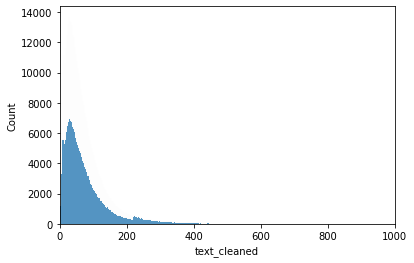

In [14]:
import matplotlib.pyplot as plt
import seaborn as sns
fig, ax = plt.subplots()
word_count = df['text_cleaned'].str.split().str.len()
sns.histplot(word_count)
plt.xlim([0,1000])
plt.show()


### TFIDF Trick

In [15]:
def get_index_to_word_dict(vectorizer):
    """ make the dictionnary index_to_word
    Parameters
    ----------
    vectorizer: sklearn.feature_extraction.text.TfidfVectorizer
        tfidf_vectorizer instance fit on a sub_dataframe. 
    
    Returns
    -------
    index_to_word: dict
        maps a word index (vectorizer.vocabulary_) to its associated word.
    """
    index_to_word = {index: word for index, word in zip(vectorizer.vocabulary_.values(), vectorizer.vocabulary_.keys())}
    return index_to_word

def get_words_with_highest_scores(scores, words, n_words_to_take):
    """
    takes scores and words of an OCR as inputs and returns 
    words with highest tfidf scores

    Parameters
    ----------
    scores: list
        list of tfidf scores.
    words: list
        list of words
    n_words_to_take: int
        number of words to select.

    Returns
    -------
    best_items: list
        list of words with highest scores.
    items: list:
        all items
    """
    items = [item for item in sorted(zip(scores, words), reverse = True)]
    best_items = items[:n_words_to_take]
    return best_items, items


def get_words_and_scores_from_tfidf_matrix(doc, cols, tfidf_matrix, index_to_word):
    """takes a document (line of tfidf matrix) and its words (columns of tfidf matrix
    and returns words of the documents with their ifidf scores
    columns are the non zero values of the tfidf matrix.

    Parameters
    ----------
    doc: int
        document index.
    cols: int
        column indexes.
    tfidf_matrix: scipy.sparse.csr.csr_matrix
        tdidf sparse matrix.
    index_to_word: dict
        maps a word index (vectorizer.vocabulary_) to its associated word.

    Returns
    -------
    best_items: list
        list of words with highest scores.
    items: list:
        list of all words.
    """
    scores = []
    words = []
    for col in cols:
        word = index_to_word[col] 
        score = tfidf_matrix[doc, col]
        words.append(word)
        scores.append(score)
    return words, scores

def text_selection(df_idx, sub_df_idx,  index_to_word, tfidf_matrix, n_words_to_take = 50):
    """ makes the text selection on a document based on the tfidf score
    
    Parameters
    ----------
    df_idx: int
        index of the document in the original dataframe
    sub_df_idx: int
        index of the document in the sub-dataframe (filtered dataframe on a given language)
    index_to_word: dict
        maps a word index (vectorizer.vocabulary_) to its associated word.
    tdidf_matrix: scipy.sparse.csr.csr_matrix
        tdidf sparse matrix for a given language.
    n_words_to_take: int
        total words to keep.
    
    Returns
    -------
    text_selection: str
        text selected after the tfidf trick.
    items: list
        list where each element is a tuple in the following format (tdidf_score, word).
        All the words in the original text are kept.
    """
    rows, cols = tfidf_matrix[sub_df_idx].nonzero()
    ## extract words and scores from tfidf matrix
    words, scores = get_words_and_scores_from_tfidf_matrix(sub_df_idx, cols, tfidf_matrix, index_to_word)
    #extract words with highest score from sentence
    best_items, items = get_words_with_highest_scores(scores, words, n_words_to_take)
    best_words = [item[1] for item in best_items]
    
    text_selection = " ".join([word for word in df["text_cleaned"].iloc[df_idx].split() if str(word).lower() in best_words])
    text_selection = " ".join(best_words)
    #text_selection_unique = remove_duplicates(text_selection)
    return text_selection, items

def text_selection_from_Series(text_Series, tfidf_matrix, index_to_word):
    """ takes a text pd.Series as input and makes the tfidf-selection for each document

    Parameters
    ----------
    text_Series: pd.Series
        pd.Series containing OCR text
    tdidf_matrix: scipy.sparse.csr.csr_matrix
        tdidf sparse matrix for a given language.
    index_to_word: dict
        maps a word index (vectorizer.vocabulary_) to its associated word.

    Returns
    -------
    text_selection_list: list
        list containing all the texts after the tfidf-selection
    items_list: list
        each element of items_list is a list containing items.
        An item is in the following format (tdidf_score, word)
        All the words in the original text are kept.
    """
    text_selection_list = []
    items_list = []
    for sub_df_idx, df_idx in enumerate(tqdm(text_Series.index)):
        text_selection_unique, items = text_selection(df_idx, sub_df_idx, index_to_word, tfidf_matrix, n_words_to_take = 30)
        text_selection_list.append(text_selection_unique)
        items_list.append(items)
    return text_selection_list, items_list

In [16]:
def remove_duplicates(text, get_keys = False):
    """takes a text and removes the duplicated words. It keeps the string's original casing"""
    D = {word.lower(): word  for word in str(text).split()}
    if get_keys:
        return " ".join(D.keys())
    else:
        return " ".join(D.values())

### Performing TFIDF Trick 

In [17]:
df["tfidf_selection"] = ""
clear_output()

In [18]:
"""takes approx 6min"""
from sklearn.feature_extraction.text import TfidfVectorizer
from IPython.display import clear_output
problematic_langs = []
df = df.reset_index(drop = True)
for lang in df["main_lang"].unique():
    print("lang:", lang)
    lang_filter = df["main_lang"]== lang 
    sub_df = df[lang_filter]
    try:
        vectorizer = TfidfVectorizer(min_df = 1, max_df = 0.8)
        tfidf_matrix = vectorizer.fit_transform(sub_df["text_cleaned"])
        index_to_word = get_index_to_word_dict(vectorizer)
        text_selection_list, items_list =  text_selection_from_Series(sub_df["text_cleaned"], tfidf_matrix, index_to_word)
        df.loc[lang_filter, "tfidf_selection"] = text_selection_list
    except:
        problematic_langs.append(lang)
    clear_output()

In [19]:
len(problematic_langs)

21

In [20]:
df.loc[df["tfidf_selection"] == "",:].shape

(229, 7)

### Intersection words trick

In [21]:
def get_intersect_words_lang(lang_dict):
    """get words that are used in all languages, for a given text.

    Parameters
    ----------
    lang_dict: dict
        dictionnary in the following format {"lang": {"prob": prob, "len_text":len_text, "text": text}}

    Returns
    -------
    intersection: str
        words used in all languages.
    """
    
    dont_take= ["kj", "kcal", "kj", "total", "free", "net", "ingredients", "ingredient", "et", "de", "fat", "mg", "cg", "g", "kg", "ml", "cl", "l", "kl", "per", "pour", "valeur", "or", "le", "la", "dont", "consommer", "poids", "net", "www", "com", "which", "of", "wt"]
    if len(lang_dict) > 1:
        sets = [set(remove_duplicates(text_cleaner(lang_dict[lang]["text"]), get_keys = True).split()) for lang in lang_dict.keys()]
        intersection =  " ".join([word for word in set.intersection(*sets) if word not in dont_take])
        return intersection
    else: 
        return ""

In [22]:
def get_intersect_words_ocr(barcode):
    """get words that are found in all images, for a given barcode.
    Parameters
    ----------
    barcode: str
        EAN - 13 digits

    Returns
    -------
    intersection: str
        words found in all images, for a given barcode.
    """
    ocr_dict = ocr_text_dict[barcode]
    dont_take= ["kj", "kcal", "kj", "total", "free", "net", "ingredients", "ingredient", "et", "de", "fat", "mg", "cg", "g", "kg", "ml", "cl", "l", "kl", "per", "pour", "valeur", "or", "le", "la", "dont", "consommer", "poids", "net", "www", "com", "which", "of", "wt"]
    if len(ocr_dict) > 1:
        sets = [set(remove_duplicates(text_cleaner(ocr_dict[key]), get_keys = True).split()) for key in ocr_dict.keys()]
        intersection = " ".join([word for word in set.intersection(*sets) if word not in dont_take])
        return intersection
    else: 
        return ""

In [23]:
"""takes approx 1min30"""
intersection_list_lang = parallel_calc(lang_dict_list, get_intersect_words_lang)
print(len([item for item in intersection_list_lang if item != ""]) / len(intersection_list_lang))
#pd.DataFrame(zip(df["code"], intersection_list), columns = ["barcode", "intersection"]).to_csv('results_intersections.csv', index = False)

0.14662308272567262


In [24]:
"""takes approx 56sec"""
intersection_list_ocr = parallel_calc(df["code"], get_intersect_words_ocr)
print(len([item for item in intersection_list_ocr if item != ""]) / len(intersection_list_ocr))
#pd.DataFrame(zip(df["code"], intersection_list), columns = ["barcode", "intersection"]).to_csv('results_intersections.csv', index = False)

0.4644321515380102


In [25]:
df["intersection_words_lang"] = intersection_list_lang
df["intersection_words_ocr"] = intersection_list_ocr

### fetch big words from images

In [40]:
from PIL import Image
import requests
import urllib
import io

def make_barcode(x):
    """ takes an EAN of 13 digits and returns an EAN in the format "XXX/XXX/XXX/XXXX """
    x = str(x)
    return "{}/{}/{}/{}".format(x[:3], x[3:6], x[6:9], x[9:])

def make_link_from_barcode(barcode, df, file = "image", keys = None):
    """creates url for json or jpg, from the barcode """
    if keys is None:
        keys = df.loc[df["code"]==barcode, "keys"].values[0]
    if isinstance(keys, str):
        keys = eval(keys)
    elif isinstance(keys, list):
        pass

    links = []
    if file == "image": file = "jpg"
    if file == "json": file = "json"
    barcode_with_slash = make_barcode(barcode)
    for key in keys:
        link = "https://world.openfoodfacts.org/images/products/{}/{}.{}".format(barcode_with_slash, key,file)
        links.append(link)
    return links

def show_images(links):
    """display images from links"""
    for link in links:
        response = requests.get(link)
        image_bytes = io.BytesIO(response.content)
        img = Image.open(image_bytes)
        img.show()



def show_images_from_barcode(barcode, df, keys = None):
    """display all the images belonging to a barcode"""
    links = make_link_from_barcode(barcode, df=df, keys = keys)
    show_images(links)

import math
import requests
def get_score_from_verticles(txt_annotations:dict):
    """the code iterates through all the anchor boxes used to detect the text.
    It finds the bigest Anchor box with the least words. The idea here is to find important words
    and usually important words are written in big print and are titles or captions so it doesn't have 
    much characters. The score computed here is detection_box_area / len_text 

    Parameters
    ----------
    txt_annotations: dict
        dictionnary containing detection boxes coordinates for a given image.

    Returns
    -------
    score: float
        highest score through iteration.
    text: str
        text found in the anchor associated with the highest score. 
    """
    txt = txt_annotations["description"]
    len_text = len(txt)
    y_min = math.inf
    y_max = -math.inf
    x_min = math.inf
    x_max = -math.inf

    verticles = txt_annotations['boundingPoly']['vertices']
    for coords in verticles:
        if 'y' in coords:
            y_min = min(coords['y'], y_min)
            y_max = max(coords['y'], y_max)
        if 'x' in coords:
            x_min = min(coords['x'], x_min)
            x_max = max(coords['x'], x_max)
    area = abs(x_max-x_min) * abs(y_max-y_min)
    score = area/len_text
    return score,txt

def get_n_most_important_words(results, word_count_limit = 10):
    """selects N unique words from an image
    
    Parameters
    ----------
    results: list:
        list of tuples, the tuples are in the following format: (score, text)
        
    word_count_limit: int
        number of words to select.

    Returns
    -------
    words_to_keep: str
        N words to keep from an image
    """
    to_keep = {}
    for items in results:
        words = items[1]
        for word in text_cleaner(words).split():
            if word not in to_keep:
                to_keep[word.lower()] = word
                if len(to_keep) == word_count_limit:
                    return " ".join(to_keep.values())
    words_to_keep =  " ".join(to_keep.values())
    return words_to_keep      



def get_big_words_from_txt_annotations(txt_annotations):
    """ selects N unique words from an image
    Parameters
    ----------
    txt_annotations: dict
        dictionnary containing detection boxes coordinates for a given image.

    Returns
    -------
    words_to_keep: str
        N words to keep
    """
    try:
        results = sorted([get_score_from_verticles(txt_a) for txt_a in txt_annotations], reverse = True)
        text = get_n_most_important_words(results, word_count_limit = 10)
    except:
        text = ""
    return text


def get_big_words_from_image(barcode, df, keys = None):
    """ selects N unique words from an image.Here, we use the url of the json, created with the barcode
    
    Parameters
    ----------
    barcode: str
        EAN - 13 digits
    df: pd.DataFrame
    keys: list, default = None
        list of keys used to create the urls. if the value is None,
        the information is fetched from the dataframe.
    
    Returns
    -------
    words_to_keep: str
        N words to keep    
    """
    texts = []
    links = make_link_from_barcode(barcode, df, file = "json", keys = keys)
    for link in links:
        try:
            response = urllib.request.urlopen(link)
            js = json.loads(response.read())
            txt_annotations = js['responses'][0]['textAnnotations'][0]
            results = sorted([get_score_from_verticles(txt_annotations)  for txt_annotations in js['responses'][0]['textAnnotations']], reverse = True)
            text = get_n_most_important_words(results, word_count_limit = 15)

        except:
            text = ""
        texts.append(text)
    return " ".join(texts)

def get_big_words_from_image_clean(barcode, df, keys = None):
    return text_cleaner(get_big_words_from_image(barcode, df, keys = keys))

In [27]:
big_words_dict = {}
i_last = -1

In [28]:
"""takes approx 7m30"""
txt_annotations_path = "../datasets/txtannotations.jsonl.gzip"
import gzip
with gzip.open(txt_annotations_path) as f:
    for i, line in enumerate(f):
        if i > i_last:
            i_last +=1
            json_str = line.decode('utf-8')
            txt_annotations = json.loads(json_str)
            barcode = list(txt_annotations.keys())[0]
            if str(barcode) in big_words_dict:
                sentences_list = [get_big_words_from_txt_annotations(txt_annotations[barcode][key]) for key in sorted(txt_annotations[barcode].keys())]
                if str(barcode) == '8480000141927':
                    problem = sentences_list
                    problem_keys = txt_annotations[barcode].keys()
                if len(big_words_dict[str(barcode)]) <= 500:
                    big_words_dict[str(barcode)] +=  " " + " ".join(sentences_list)
            else:
                sentences_list = [get_big_words_from_txt_annotations(txt_annotations[barcode][key]) for key in sorted(txt_annotations[barcode].keys())]
                big_words_dict[str(barcode)] = " ".join(sentences_list)

        if i %250000 == 0:
            print(i)
  

0
250000
500000
750000
1000000


In [29]:
len(big_words_dict)

363547

In [41]:
path = "barcodes_dict_with_new_ones.pkl"
with open(path, 'rb') as file:
    big_words_dict = pickle.load(file)
len(big_words_dict)

375415

In [42]:
df["big_words"] = df["code"].apply(lambda x: big_words_dict[str(x)] if str(x) in big_words_dict else '')

In [43]:
df["big_words"].str.split().str.len().sort_values(ascending = False)

142417    140
141865    112
85698     110
157713    110
190957    110
         ... 
448646      0
448647      0
448648      0
448650      0
596549      0
Name: big_words, Length: 596550, dtype: int64

### Make output df

In [76]:
df["word_selection"] = (
    df["big_words"].astype(str) + ". " +
    df["intersection_words_ocr"].fillna("").astype(str) + ". " +
    df["intersection_words_lang"].fillna("").astype(str) + ". " +
    df.apply(
        lambda x: x["original_text_cleaned"] if len(x["original_text_cleaned"]) < 500 
        else x["text_cleaned"]if len(x["text_cleaned"]) < 500
        else (remove_duplicates(x["text_cleaned"]) if len(remove_duplicates(x["text_cleaned"]).split()) < 80
        else x["tfidf_selection"]) ,axis = 1).astype(str)
    )


In [92]:
df.to_pickle("dataset.pkl")

In [78]:
empty_or_noise = df["word_selection"].str.len() < 10
print("noise or empty lines:", empty_or_noise.sum())
df_final = df[~empty_or_noise]
print(df_final.shape)



noise or empty lines: 194
(596356, 12)


### Check random lines

In [96]:
import pandas as pd
df = pd.read_pickle("dataset.pkl")
df["code"] = df["code"].astype(str)

empty_or_noise = df["word_selection"].str.len() < 10
print("noise or empty lines:", empty_or_noise.sum())
df_final = df[~empty_or_noise]
print(df_final.shape)


noise or empty lines: 194
(596356, 12)


In [128]:
i = np.random.choice(range(df_final.shape[0]))
#i = 10157 # maitre coq volaille
barcode = df_final["code"].iloc[i]
print(i)
print(df_final["word_selection"].iloc[i])
print(len(df_final["word_selection"].iloc[i].split()))
print(barcode)
show_images_from_barcode(barcode, df_final)

22627
ancel FABRIQUE EN Alsace Savourez Véritables Grands Bretgels SANS COLORANT BLÉ ORGE malt Salés ingrédients Liste des Biscuits farine huile tournesol Huile Biscuits salés Liste des ingrédients farine BLÉ sel. huile. . Biscuits salés Liste des ingrédients farine BLÉ huile tournesol Sel extrait malt ORGE FADRIUE EN Alsace ancel Véritables Grands Bretzels SANS COLORANT CONSERVATEUR PALME Ssachets fraicheur so produit contient portions Par Portion valeurs nutritionnelles moyennes énergétique Matières Grasses acides gras saturés Glucides sucres Protéines Apport référence un adulte type Ces les peuvent varier selon age sexe activité
89
3027030010660


In [73]:
df_final["text_cleaned"].iloc[i]

'Valeurs nutritionnelles moyennes gr acides gras acides gras monoinsaturés acides greenwooz HUILE'

In [87]:
big_words_dict[barcode]

'Nestle Cerealo Ptite PÉPITES FONDANTES Chocplat Biscuite au lait sans CE ot avae Bcide ENFANTS blé en longtemps Nestlé variée'

In [127]:
#5000354914829
#3011360020178
#3278910707327
#5400141165043 151247
#3083681008616
import numpy as np
#18546
#i = 63663
#i = np.random.choice(range(df_final.shape[0]))
#i = 18546
input_text = df_final["texts"].iloc[i]
final_selection = df_final["word_selection"].iloc[i]
text_clean = df_final["text_cleaned"].iloc[i]
text_tf = df_final["tfidf_selection"].iloc[i]
text_insct_lang = df_final["intersection_words_lang"].iloc[i]
text_insct_ocr = df_final["intersection_words_ocr"].iloc[i]
barcode = df_final["code"].iloc[i]


print(barcode)
print(re.sub(r"\n", " ", input_text))
print("____ final selection ____")
print(final_selection)
print("____ text after cleaning ____")
print(text_clean)
print("____ text selection with tdidf score")
print(text_tf)
print("___ text selection with intersection between languages words lang")
print(text_insct_lang)
print("___ text selection with intersection between languages words ocr")
print(text_insct_ocr)
print("___ text selection - big words from image")
if barcode in big_words_dict:
    print(big_words_dict[barcode])
#show_images_from_barcode(barcode, df = df_final)

3325815010738
Rillettes de Thon Ingredients Thon 52%, huile de colza, eau, poudre de blanc d'oeuf (sol), protéines de lait, fibres de pommes de terre, sel, épaississants farne de graines de caroube, carraghénanes Valeurs nutritionnelles moyennes pour 100g Energie 1163K 281Kcal, Matiéres Grasses 24g dont acides gras saturés 1,8g, Glucides 0,6g dont sucres <0,5g; Protéines 15g; Sel 1,0g A consommer de préférences avant le: voir sur le coté de la boîte Apres ouverture, conserver au réfrigérateur et à consommer dans les deux jours. SAS les Délices de la mer ZA des 4 voies 22170 Plélo Poids Net: 80g FR 22.182.005 CE 3325815 010738  Rillettes de Thon Ingredients Thon 52 % , huile de colza, eau, poudre de blanc d'oeuf (sol), protéines de lait, ibres de pommes de terre, sel, épaississants farine de graines de caroube, camraghénanes. Valeurs nutritionnelles moyennes pour 100g Energie 1163K 281Kcal; Matiéres Grasses : 24g dont acides gras saturés 1,8g, Glucides 0,6g dont sucres <0,5g, Protéines 

In [74]:
text_cleaner(input_text)

'Valeurs nutritionnelles moyennes gr Matières acides gras acides gras monoinsaturés acides gras greenwooz HUILE TOURNESOL VIERGE BI PRESSION À FROID MADE IN FRANCE'

In [257]:
barcode = "7622210449283"
get_big_words_from_image_clean(barcode, df = df_final)

'Information nutritionnelle Energie Matières grasses acides gras saturés Glucides sucres PRINCE CHOCOLAT NOUV ELLI RECETE Ence re illeure AU BLE PRINCE CHAR CHOCOLAT au blé complec PRINCE CHOCOLAT EAGUE PAQUET ACHET USTICE DU AU CHANCE GAGNER RI JI FR BISCUITS FOURRÉS PARFUM Ingrédients Céréale farime BLE farine BLÉ complète Information Nutritionnelle Energie Matières grasses acides gras saturés Glucides sucres'